# Modeling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
import shap
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('preprocessed_df.csv')

## Data Preprocess
- We want to build a preprocessor for numerical and categorical features.
- Some of the models would prefer onehot encoded categorical features, others just label encoded so we build two different processors.
- We can think of a way of balancing the dataset such as synthetic augmentation or use models that are resilient to unbalanced dataset (Random Forests, Boosted models).

In [3]:
X, y = data.drop('Exited', axis=1), data['Exited']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Preprocessors

In [5]:
# Preprocessing pipelines for numerical and categorical features
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance (EUR)', 'NumberOfProducts', 'EstimatedSalary']
categorical_features = ['Country', 'Gender', 'Sentiment', 'EstimatedSalary_Category', 'CreditScore_Category', 'Age_Category', 'Balance (EUR)_Category']

preprocessor_onehot = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
        ], remainder='passthrough')

preprocessor_label = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OrdinalEncoder(), categorical_features)
        ], remainder='passthrough')

def create_pipeline(model, preprocessor, augment=False):
    if augment:
        return ImbPipeline(steps=[('preprocessor', preprocessor),
                                  ('smote', SMOTE(random_state=42)),
                                  ('classifier', model)])
    else:
        return Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', model)])


## Model Selection
- In this section we try different models with different parameter space.
- We create a method that allow us to introduce augmentation in the training data.
- We select the best performing model in terms of recall since we are interested in getting all the churning clients (clients on which we want to focus our business decisions). It is acceptable to produce more false positive rather than a false negative. For instance if you predict that a user is going to leave and you spend money/time on it, at least it is not a waste. Instead if you predict a user would stay and it leaves you are in a very bad spot.

In [6]:
def build_models(augment=False):
    models = [
        {
            'name': 'Logistic Regression',
            'estimator': create_pipeline(LogisticRegression(solver='liblinear'), preprocessor_onehot, augment),
            'params': {
                'classifier__C': [0.1, 1.0, 10],
                'classifier__penalty': ['l1', 'l2']
            }
        },
        {
            'name': 'Random Forest',
            'estimator': create_pipeline(RandomForestClassifier(random_state=42, n_jobs=-1), preprocessor_label, augment),
            'params': {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__max_depth': [None, 10, 20, 50],
                'classifier__min_samples_split': [2, 5, 10],
                'classifier__min_samples_leaf': [1, 2]
            }
        },
        {
            'name': 'XGBoost',
            'estimator': create_pipeline(XGBClassifier(random_state=42, n_jobs=-1), preprocessor_label, augment),
            'params': {
                'classifier__n_estimators': [100, 200, 250, 300],
                'classifier__learning_rate': [0.01, 0.1, 0.05],
                'classifier__max_depth': [3, 5, 7],
                'classifier__gamma': [0, 0.1, 0.2],
                'classifier__min_child_weight': [1, 3, 5],
                'classifier__scale_pos_weight': [1, 2],
            }
        },
        {
        'name': 'Support Vector Classifier',
        'estimator': create_pipeline(SVC(probability=True, random_state=42), preprocessor_onehot, augment),
        'params': {
            'classifier__C': [5.0, 10, 15],
            'classifier__kernel': ['rbf'],
            'classifier__gamma': ['scale', 'auto']
        }
        }
    ]
    return models

In [7]:
def model_scoring(models, best_models, scoring='recall'):
    for model in models:
        print(f"Training {model['name']}...")
        grid_search = GridSearchCV(model['estimator'], model['params'], cv=5, n_jobs=-1, scoring=scoring)
        grid_search.fit(X_train, y_train)
        best_models[model['name']] = {
            'best_estimator': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_
        }
        print(f"Best parameters for {model['name']}: {grid_search.best_params_}")
        print(f"Best cross-validation {scoring} score for {model['name']}: {grid_search.best_score_}")
        print("\n")

In [8]:
def evaluate_models(best_models, X_test, y_test, plot=True):
    for name, model in best_models.items():
        print(f"Evaluating {name}...")
        y_pred = model['best_estimator'].predict(X_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
        print(f"Classification Report for {name}:\n{class_report}")
        if plot:
            plt.figure(figsize=(3, 1.5))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            plt.title(f"Confusion Matrix for {name}")
            plt.show()

In [9]:
models = build_models()
models_augmented = build_models(augment=True)

In [10]:
best_models = {}
best_models_aug = {}

## Training and Cross Validation
- In this section we train the models first without augmentation and then with augmentation.
- We store the results in two different dictionaries.
- The logic behind inplace change is that if we restart the training with less models we do not overwrite the previous run.

In [19]:
model_scoring(models, best_models)

Training Logistic Regression...
Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Best cross-validation recall score for Logistic Regression: 0.3711656441717791


Training Random Forest...
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best cross-validation recall score for Random Forest: 0.46993865030674853


Training XGBoost...
Best parameters for XGBoost: {'classifier__gamma': 0.1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 250, 'classifier__scale_pos_weight': 2}
Best cross-validation recall score for XGBoost: 0.6337423312883435


Training Support Vector Classifier...
Best parameters for Support Vector Classifier: {'classifier__C': 15, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best cross-validation recall score for Support

In [20]:
model_scoring(models_augmented, best_models_aug)

Training Logistic Regression...
Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Best cross-validation recall score for Logistic Regression: 0.7061349693251534


Training Random Forest...
Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best cross-validation recall score for Random Forest: 0.5920245398773006


Training XGBoost...
Best parameters for XGBoost: {'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 2}
Best cross-validation recall score for XGBoost: 0.9030674846625768


Training Support Vector Classifier...
Best parameters for Support Vector Classifier: {'classifier__C': 5.0, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Best cross-validation recall score for Support V

## Evaluation
- We evaluate the models on the test set.
- We plot the confusion matrix and the classification report.

Evaluating Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1593
           1       0.69      0.32      0.44       407

    accuracy                           0.83      2000
   macro avg       0.77      0.64      0.67      2000
weighted avg       0.82      0.83      0.81      2000



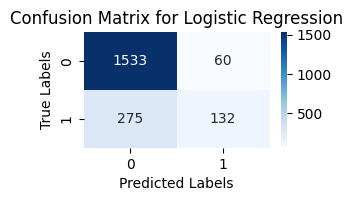

Evaluating Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.80      0.47      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000



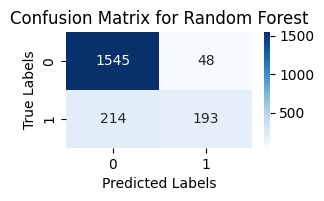

Evaluating XGBoost...
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1593
           1       0.67      0.61      0.64       407

    accuracy                           0.86      2000
   macro avg       0.79      0.77      0.77      2000
weighted avg       0.85      0.86      0.86      2000



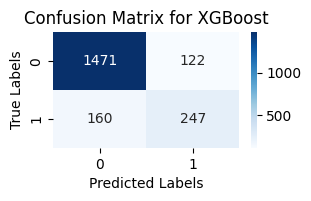

Evaluating Support Vector Classifier...
Classification Report for Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1593
           1       0.71      0.52      0.60       407

    accuracy                           0.86      2000
   macro avg       0.80      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



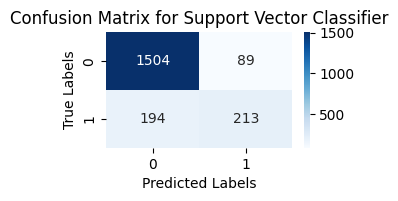

In [176]:
evaluate_models(best_models, X_test, y_test)

Evaluating Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1593
           1       0.42      0.69      0.53       407

    accuracy                           0.75      2000
   macro avg       0.66      0.73      0.68      2000
weighted avg       0.81      0.75      0.76      2000



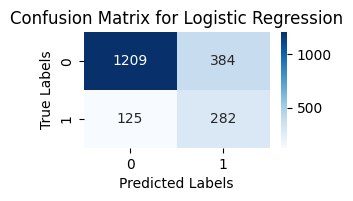

Evaluating Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1593
           1       0.68      0.61      0.65       407

    accuracy                           0.86      2000
   macro avg       0.79      0.77      0.78      2000
weighted avg       0.86      0.86      0.86      2000



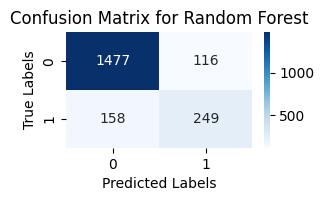

Evaluating XGBoost...
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.49      0.64      1593
           1       0.31      0.88      0.46       407

    accuracy                           0.57      2000
   macro avg       0.62      0.69      0.55      2000
weighted avg       0.81      0.57      0.61      2000



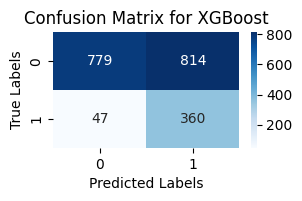

Evaluating Support Vector Classifier...
Classification Report for Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1593
           1       0.61      0.65      0.63       407

    accuracy                           0.84      2000
   macro avg       0.76      0.77      0.76      2000
weighted avg       0.85      0.84      0.85      2000



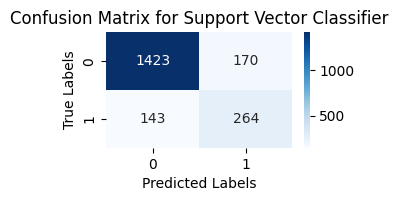

In [177]:
evaluate_models(best_models_aug, X_test, y_test)

## Comments on Model selection
- It seems that with not augmented training dataset the performance of the models are worse, in terms of positive class recall and f1 score.
- The best model is SVM Classifier with a recall score of 0.65 on the positive classe (Exited). I consider it the best since it maximise the recall having at the same time a low number of false negative (bottom left in the confusion matrix). If we want a more aggressive model we could use the Logistic Regression Classifier since it shows more inclination on predicting the positive class.

### Final model
- Retrain on all the training dataset to get the final model

### Feature importance exploration
- We can use shap to understand the importance of the features.
- This could give us a better understanding of the model reasoning and an overview on possible issues or improvements.
- It can also lead our business decisions giving us what is most important to focus on.

In [29]:
params = {k.replace('classifier__',''): v for k,v in best_models_aug['Support Vector Classifier']['best_params'].items()}

In [12]:
X_train_transformed = preprocessor_onehot.fit_transform(X_train)
X_test_transformed = preprocessor_onehot.fit_transform(X_test)
final_model = SVC(**params, probability=True, random_state=42).fit(X_train_transformed, y_train)

In [26]:
# This method allow to extract the names of the features otherwise they get lost in the processing
def get_feature_names(column_transformer, input_features=None):
    """Get feature names from a ColumnTransformer."""
    # Create an empty list to hold the names of the features
    feature_names = []

    # If input_features is None, assume the input features are in the same order as the transformers
    if input_features is None:
        input_features = column_transformer.feature_names_in_

    # Loop through each transformer
    for name, transformer, columns in column_transformer.transformers_:
        # Handle the 'drop' and 'passthrough' cases
        if transformer == 'drop':
            continue
        elif transformer == 'passthrough':
            if isinstance(columns, slice):
                feature_names.extend(input_features[columns])
            else:
                feature_names.extend([input_features[col] for col in columns])
            continue

        # Get the transformer feature names
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out()
        else:
            names = input_features[columns]

        # If the transformer is a pipeline, get the names from the last step
        if isinstance(transformer, Pipeline):
            names = get_feature_names(transformer[-1], names)

        feature_names.extend(names)
    return feature_names

In [27]:
feature_names = get_feature_names(preprocessor_onehot)

In [ ]:
explainer = shap.Explainer(final_model.predict, X_train_transformed)

In [33]:
X_test_downsample = shap.sample(X_test_transformed, 200)
shap_values = explainer(X_test_downsample)

PermutationExplainer explainer: 201it [13:21,  4.05s/it]                        


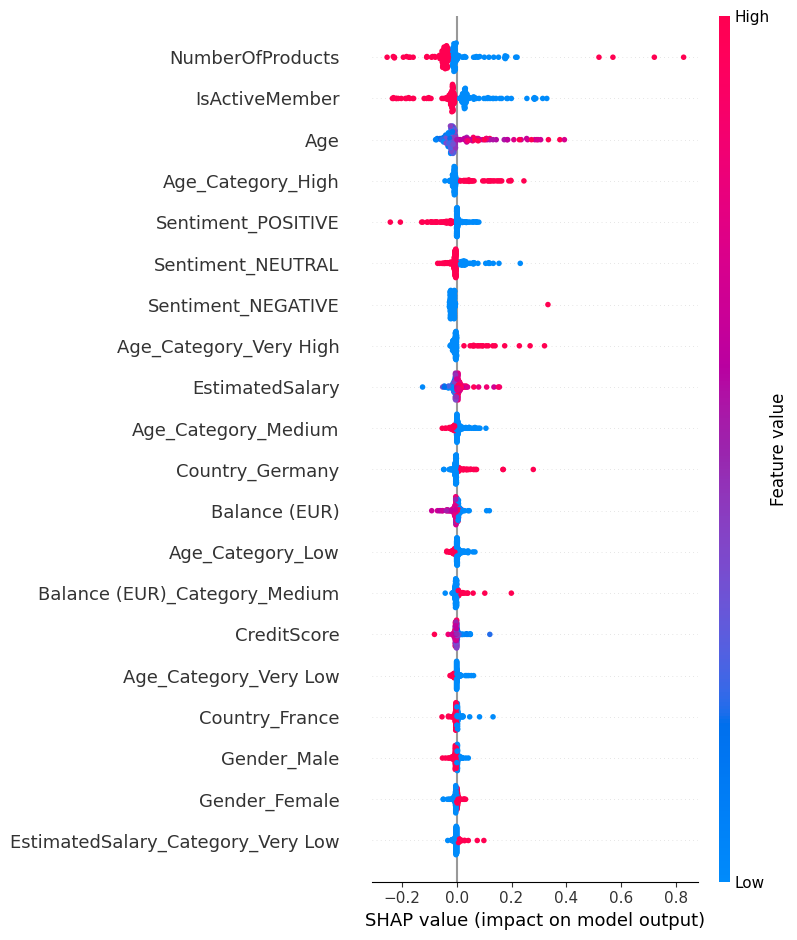

In [34]:
shap.summary_plot(shap_values, X_test_downsample, feature_names=feature_names)

### Comments on feature importance
- NumberOfProducts seems to have sometimes a very positive impact and other times a very negative impact. This could mean that having a different number of products lead to very different outcomes. A user with more products (red on the left) has a lower probability to leave because it has invested more money and time, while we observe also the opposite (blue on the right).
- Same for active members. Being an active member negatively correlates with the target since an active member is probably more interested in being a client, a not active user on the other hand is more likely to leave.
- Age, together with Age Category High (Very High) all in the top positions is telling us that being older lead to a higher churn probability.
- Positive sentiment is negative correlated with the positive class prediction as expected while even if we have little representation of negative sentiment we can see the red dot meaning that a negative sentiment is highly correlated with the exited class.

### Possible business outcomes
- Given the result of our analysis it is reasonable to say that our model successfully predicts what customers are leaving out platform/prduct.
- The way this model can be used are multiple:
    1. Regularly ask the model to update a "status" table where we store the information about each user on whether is about to leave or not. We can focus our ad campaign or personalised discount and offers to the users that are predicted as leavers.
    2. Regularly update the model and use it to understand what are the most important aspects of people that are leaving to address the problem in that direction. For instance given the feature importance above we should consider addressing already the elderly population of our service or stimulate the multiple product adoption or again try to engage the people on out platform to be more active since it leads to less leaving probability.

### Technical considerations
- The model could be served as a microservice exposing http endpoints.
- The training pipeline could be automated in a way that when triggered it automatically generate the training dataset from our clients data and train the model against a well defined test set.
- The user status described in point 1 could be a simple text file/csv stored on a storage service.
- The status update could trigger alarms in case a "0" user would be predicted as "1".
- This alarms could be gathered and visualised on a dashboard/report to allow a clear view on who are the clients that are likely to leave and on which we should focus our efforts.